In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *

In [2]:
N_objects = 2000
noise_sigma = 1e-3
num_nyquist_samples_list = onp.arange(16, 33, 2)
num_bootstrap_samples = 5


objects_dict = {
  'delta_uniform': lambda : np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)]),
  'delta_nonuniform': lambda: np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=True) for i in range(N_objects)]),
  'white_noise': lambda : np.array([sample_amplitude_object('white_noise') for i in range(N_objects)]),
  'pink_noise': lambda : np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)]),
  '8_deltas_uniform': lambda :np.array([sample_amplitude_object('delta', num_deltas=8, gaussian_mixture_position=False) for i in range(N_objects)]),
  '8_deltas_nonuniform': lambda : np.array([sample_amplitude_object('delta', num_deltas=8, gaussian_mixture_position=True) for i in range(N_objects)]),
}

# num_nyquist_samples = int(NUM_NYQUIST_SAMPLES // 2)
num_nyquist_samples = NUM_NYQUIST_SAMPLES

mi_by_object = {}
for name, objects_fn in objects_dict.items():
  print(name)
  mutual_information = []
  for num_nyquist_samples in tqdm(num_nyquist_samples_list):
    runs = []
    for i in range(num_bootstrap_samples):
      initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(
          objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples)
      runs.append(optimized_mi)
    mutual_information.append(np.array(runs).max())
  mi_by_object[name] = mutual_information

delta_uniform


  0%|                                                         | 0/9 [00:00<?, ?it/s]

initial loss -4.872387290997615
initial loss -4.154388715687787
initial loss -4.248011867050076
initial loss -4.463198658665466
initial loss -4.110838572929257


 11%|█████▎                                          | 1/9 [05:11<41:31, 311.39s/it]

initial loss -3.925056673932515
initial loss -4.288534610063487
initial loss -3.3063104521910414
initial loss -4.254971428638758
initial loss -4.561979237048528


 22%|██████████▋                                     | 2/9 [08:31<28:41, 245.90s/it]

initial loss -4.001551621336263
initial loss -3.824820839559899
initial loss -3.957862086650053
initial loss -4.216833787911449
initial loss -4.41999997275611


 33%|████████████████                                | 3/9 [12:57<25:31, 255.32s/it]

initial loss -4.13065776659569
initial loss -3.8393383345173597
initial loss -3.561061630374071
initial loss -3.8148661377647186
initial loss -3.943178195667495


 44%|█████████████████████▎                          | 4/9 [16:59<20:50, 250.06s/it]

initial loss -3.9872805853174382
initial loss -3.4740637710677267
initial loss -3.8751806130645385
initial loss -4.1627246581635475
initial loss -3.600970613068306


 56%|██████████████████████████▋                     | 5/9 [21:11<16:42, 250.53s/it]

initial loss -4.0128847930716525
initial loss -4.09237531608087
initial loss -3.5364796309895548
initial loss -4.002396486300726
initial loss -3.776299784399577


 67%|████████████████████████████████                | 6/9 [24:53<12:02, 240.81s/it]

initial loss -3.6109900541623667
initial loss -3.506782357307935
initial loss -3.936727628727437
initial loss -3.222506568308944
initial loss -3.660421084851895


 78%|█████████████████████████████████████▎          | 7/9 [28:42<07:53, 236.91s/it]

initial loss -3.0571780019159904
initial loss -3.703266217825148
initial loss -3.4058049717412526
initial loss -3.499844854233075
initial loss -3.53938264638905


 89%|██████████████████████████████████████████▋     | 8/9 [47:13<08:35, 515.27s/it]

initial loss -3.593138108339023
initial loss -3.258589981672742
initial loss -3.805969539652165
initial loss -3.1959516612789867
initial loss -3.510488279493206


100%|████████████████████████████████████████████████| 9/9 [56:56<00:00, 379.61s/it]


delta_nonuniform


  0%|                                                         | 0/9 [00:00<?, ?it/s]

initial loss -3.1561106422926244
initial loss -3.334470187565266
initial loss -3.4317310704401525
initial loss -3.475606713755357
initial loss -3.680783583944689


 11%|█████▎                                          | 1/9 [05:23<43:06, 323.25s/it]

initial loss -3.4448047774133745
initial loss -3.3405564862497785
initial loss -3.05847580821571
initial loss -2.944759539225922
initial loss -3.544718045811749


 22%|██████████▋                                     | 2/9 [10:29<36:33, 313.41s/it]

initial loss -3.0483608868253196
initial loss -3.0671369653615423
initial loss -3.296695730750726
initial loss -3.657898757405577
initial loss -2.7450868350700213


 33%|████████████████                                | 3/9 [14:25<27:46, 277.77s/it]

initial loss -3.0897001418288625
initial loss -3.0901761894700805
initial loss -2.9967874354803294
initial loss -2.98339351399061
initial loss -3.3852539713112884


 44%|█████████████████████▎                          | 4/9 [18:20<21:45, 261.09s/it]

initial loss -2.972999474375446
initial loss -2.740077604959709
initial loss -3.114749689242939
initial loss -2.9326603756761758
initial loss -3.0463307904237853


 56%|██████████████████████████▋                     | 5/9 [22:11<16:40, 250.23s/it]

initial loss -3.0467678572272963
initial loss -3.0592008750801774
initial loss -2.9530951296698675
initial loss -2.968105092604985
initial loss -3.011689248733964


 67%|████████████████████████████████                | 6/9 [26:20<12:28, 249.65s/it]

initial loss -2.4393108566655908
initial loss -2.656154812987944
initial loss -2.8565482964744935
initial loss -2.854885776578965
initial loss -2.516235624064079


 78%|█████████████████████████████████████▎          | 7/9 [30:31<08:20, 250.37s/it]

initial loss -2.584877184930068
initial loss -2.5857288039730197
initial loss -2.7200787390549324
initial loss -2.8819284090247343
initial loss -2.9391241892683535


 89%|██████████████████████████████████████████▋     | 8/9 [41:21<06:17, 377.31s/it]

initial loss -2.5385314534821593
initial loss -2.629268316403399
initial loss -2.42627184365708
initial loss -2.634780828549725
initial loss -2.7016493124453724


100%|████████████████████████████████████████████████| 9/9 [51:06<00:00, 340.71s/it]


white_noise


  0%|                                                         | 0/9 [00:00<?, ?it/s]

initial loss -0.9559116614804661
initial loss -0.5790555829819786
initial loss -0.5251415657062151
initial loss -0.6418041705332622
initial loss -0.9748991652503387


 11%|█████▎                                          | 1/9 [03:18<26:25, 198.15s/it]

initial loss -0.7099538238488526
initial loss -0.6443261996382527
initial loss -0.6331169856876716
initial loss -0.6498241607813264
initial loss -0.440191152455697


 22%|██████████▋                                     | 2/9 [06:15<21:39, 185.63s/it]

initial loss -0.46274683371111225
initial loss -0.5598346220392436
initial loss -0.5430755544651716
initial loss -0.70575757019171
initial loss -0.6846898334372361


 33%|████████████████                                | 3/9 [09:24<18:44, 187.46s/it]

initial loss -0.5500685748338835
initial loss -0.44794528701212977
initial loss -0.4950091036324289
initial loss -0.3840100324874296
initial loss -0.5069923479081333


 44%|█████████████████████▎                          | 4/9 [12:39<15:51, 190.27s/it]

initial loss -0.38457906650989315
initial loss -0.5540064815394831
initial loss -0.3625049381276051
initial loss -0.45326302581064803
initial loss -0.46859786857571006


 56%|██████████████████████████▋                     | 5/9 [15:50<12:42, 190.74s/it]

initial loss -0.3818693384182938
initial loss -0.3999327474308901
initial loss -0.31346832020092724
initial loss -0.3550659966940781
initial loss -0.4043028683040437


 67%|████████████████████████████████                | 6/9 [19:11<09:42, 194.14s/it]

initial loss -0.3453447277119665
initial loss -0.2518912784127902
initial loss -0.3382677391464312
initial loss -0.34848710414952627
initial loss -0.26480449001870254


 78%|█████████████████████████████████████▎          | 7/9 [22:39<06:37, 198.63s/it]

initial loss -0.29151317783931896
initial loss -0.4384885665709434
initial loss -0.3609829661454855
initial loss -0.36544947809091793
initial loss -0.2303660091411227


 89%|██████████████████████████████████████████▋     | 8/9 [34:50<06:08, 368.19s/it]

initial loss -0.4457936576628876
initial loss -0.27743040449313927
initial loss -0.21366475752538883
initial loss -0.20384511123433208
initial loss -0.3220016597750431


100%|████████████████████████████████████████████████| 9/9 [56:23<00:00, 375.90s/it]


pink_noise


  0%|                                                         | 0/9 [00:00<?, ?it/s]

initial loss -1.026054574846118
initial loss -0.8933819154185973
initial loss -1.1249999435997986
initial loss -0.8810981188935296
initial loss -1.0708470852151262


 11%|█████▎                                          | 1/9 [04:00<32:02, 240.34s/it]

initial loss -0.8299231903701898
initial loss -0.8873612463613806
initial loss -0.8209377986850238
initial loss -0.8145353061675734
initial loss -1.0469238429606478


 22%|██████████▋                                     | 2/9 [07:35<26:17, 225.39s/it]

initial loss -0.6574450193849954
initial loss -0.6780927714100845
initial loss -0.6307818038413793
initial loss -0.9353486159925746
initial loss -0.7694732086622749


 33%|████████████████                                | 3/9 [11:27<22:51, 228.55s/it]

initial loss -0.5245827940243566
initial loss -0.6074318451979163
initial loss -0.7284659935215363
initial loss -0.796535858055844
initial loss -0.7493188199712902


 44%|█████████████████████▎                          | 4/9 [15:24<19:18, 231.67s/it]

initial loss -0.4967192291571694
initial loss -0.6304625453056072
initial loss -0.6120541570502327
initial loss -0.5069300597845792
initial loss -0.3161511025063634


 56%|██████████████████████████▋                     | 5/9 [19:35<15:55, 238.81s/it]

initial loss -0.348711856762766
initial loss -0.4528032828800701
initial loss -0.3861629057070739
initial loss -0.6645456447889156
initial loss -0.40112600274341786


 67%|████████████████████████████████                | 6/9 [23:55<12:17, 245.97s/it]

initial loss -0.42961879323831587
initial loss -0.4748145341889005
initial loss -0.4494422190819119
initial loss -0.40041064161592715
initial loss -0.475111280031774


 78%|█████████████████████████████████████▎          | 7/9 [28:20<08:24, 252.15s/it]

initial loss -0.34092952661516335
initial loss -0.46426347270917945
initial loss -0.28638262979133944
initial loss -0.37612322625755445
initial loss -0.4621244815556919


 89%|██████████████████████████████████████████▋     | 8/9 [45:00<08:10, 490.17s/it]

initial loss -0.456235662151025
initial loss -0.3833458068681108
initial loss -0.29219291039594275
initial loss -0.27857292244859844
initial loss -0.438130068271827


100%|██████████████████████████████████████████████| 9/9 [1:00:14<00:00, 401.57s/it]


8_deltas_uniform


  0%|                                                         | 0/9 [00:00<?, ?it/s]

initial loss -2.7415690636290475
initial loss -2.279682046458019
initial loss -2.9599834968490395
initial loss -3.1025437698475558
initial loss -2.886948618263471


 11%|█████▎                                          | 1/9 [03:37<29:00, 217.61s/it]

initial loss -2.879893056899982
initial loss -2.911944859325416
initial loss -2.4263705639066697
initial loss -2.9916307319596114
initial loss -3.2623017629946713


 22%|██████████▋                                     | 2/9 [06:37<22:49, 195.68s/it]

initial loss -2.5838466485184504
initial loss -2.4481429346632213
initial loss -2.470306106380527
initial loss -2.459130568606314
initial loss -3.0253008392747476


 33%|████████████████                                | 3/9 [10:06<20:09, 201.56s/it]

initial loss -2.8258027151587086
initial loss -2.437408563280668
initial loss -2.43157711049544
initial loss -2.7219383073025307
initial loss -2.514434912019922


 44%|█████████████████████▎                          | 4/9 [13:41<17:15, 207.01s/it]

initial loss -2.3826475992722984
initial loss -2.2230939636113365
initial loss -2.4872630791767762
initial loss -2.0496550024203968
initial loss -2.6036300112455173


 56%|██████████████████████████▋                     | 5/9 [17:03<13:40, 205.11s/it]

initial loss -2.393560054127675
initial loss -1.9974754897593916
initial loss -1.8974341688145557
initial loss -1.973461428925529
initial loss -1.8685854975827134


 67%|████████████████████████████████                | 6/9 [20:48<10:35, 211.72s/it]

initial loss -2.060982857239532
initial loss -2.2175692521564976
initial loss -2.39800885050548
initial loss -2.1975763512869197
initial loss -1.940039816902904


 78%|█████████████████████████████████████▎          | 7/9 [24:38<07:15, 217.96s/it]

initial loss -2.3468494021385036
initial loss -2.207295202604215
initial loss -2.1204241508980277
initial loss -2.225972927504306
initial loss -2.256620107414494


 89%|██████████████████████████████████████████▋     | 8/9 [33:34<05:19, 319.19s/it]

initial loss -2.324412954599037
initial loss -2.1279490949182396
initial loss -2.0919140488452066
initial loss -1.936273812306323
initial loss -2.021629333058067


100%|████████████████████████████████████████████████| 9/9 [40:51<00:00, 272.40s/it]


8_deltas_nonuniform


  0%|                                                         | 0/9 [00:00<?, ?it/s]

initial loss -2.491869981648207
initial loss -2.0581241619461776
initial loss -2.2929372344296057
initial loss -2.478032936204184
initial loss -2.2882043402398518


 11%|█████▎                                          | 1/9 [04:46<38:09, 286.24s/it]

initial loss -2.419971968995595
initial loss -2.0585777401445986
initial loss -2.1568969321562133
initial loss -2.1857536183322277
initial loss -2.358546234111608


 22%|██████████▋                                     | 2/9 [09:07<31:41, 271.70s/it]

initial loss -2.099096220957387
initial loss -1.9471289378378343
initial loss -2.27564146664497
initial loss -2.0594316670486505
initial loss -2.0225990065972232


 33%|████████████████                                | 3/9 [13:46<27:29, 274.90s/it]

initial loss -1.9491745830238627
initial loss -2.0659317579546075
initial loss -1.9546289342725727
initial loss -1.9421822977179082
initial loss -2.067631745038868


 44%|█████████████████████▎                          | 4/9 [18:33<23:18, 279.77s/it]

initial loss -1.7357688124424397
initial loss -1.7744132741094891
initial loss -1.9015648680493122
initial loss -1.821846669959322
initial loss -1.920392177722203


 56%|██████████████████████████▋                     | 5/9 [22:58<18:17, 274.46s/it]

initial loss -1.571130027122678
initial loss -1.9587953491985843
initial loss -1.772353601234436
initial loss -1.4517351564045722
initial loss -1.9434514284391584


 67%|████████████████████████████████                | 6/9 [27:52<14:03, 281.11s/it]

initial loss -1.5827329896640885
initial loss -1.4799632194994063
initial loss -1.778080402004034
initial loss -1.594084346740798
initial loss -1.6247464515806485


 78%|█████████████████████████████████████▎          | 7/9 [32:55<09:36, 288.26s/it]

initial loss -1.6064662475800728
initial loss -1.4206884093840002
initial loss -1.6629777134707089
initial loss -1.3000961547940209
initial loss -1.6321916237736096


 89%|██████████████████████████████████████████▋     | 8/9 [40:29<05:40, 340.81s/it]

initial loss -1.7141819181289601
initial loss -1.3033632269893705
initial loss -1.7864004500959294
initial loss -1.6201103310175657
initial loss -1.6834091556054478


100%|████████████████████████████████████████████████| 9/9 [48:09<00:00, 321.09s/it]


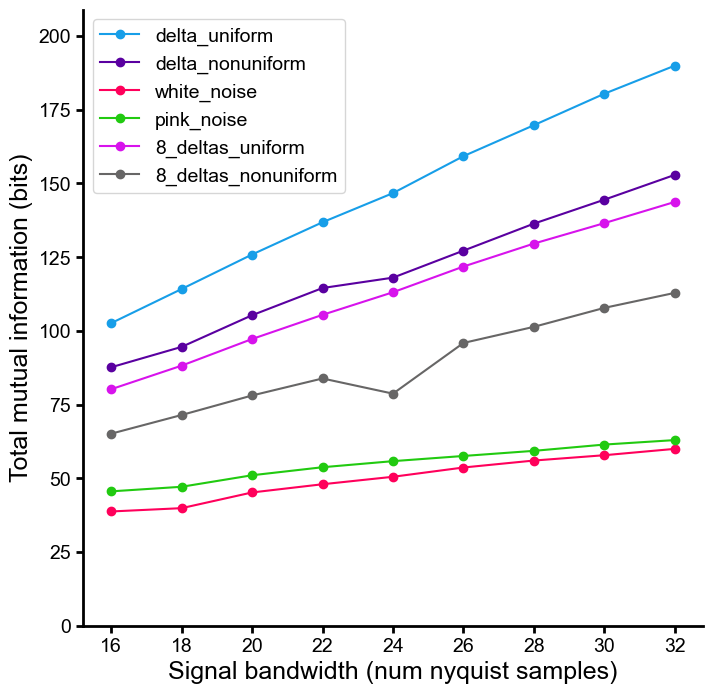

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():

    total_mi = np.array(mutual_information) * num_nyquist_samples_list
    ax.plot(num_nyquist_samples_list, total_mi, 'o-', label=object_name)
    ax.set_xlabel('Signal bandwidth (num nyquist samples)')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

clear_spines(ax)
ax.legend()